In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_root = "data/"
# Load datasets
products_file = data_root + "PRODUCTS_TAKEHOME.csv"
transactions_file = data_root + "TRANSACTION_TAKEHOME.csv"
users_file = data_root + "USER_TAKEHOME.csv"
products_df = pd.read_csv(products_file)
transactions_df = pd.read_csv(transactions_file)
users_df = pd.read_csv(users_file)

# Products Dataset cleaning

First, we will look at the missing values in each column.

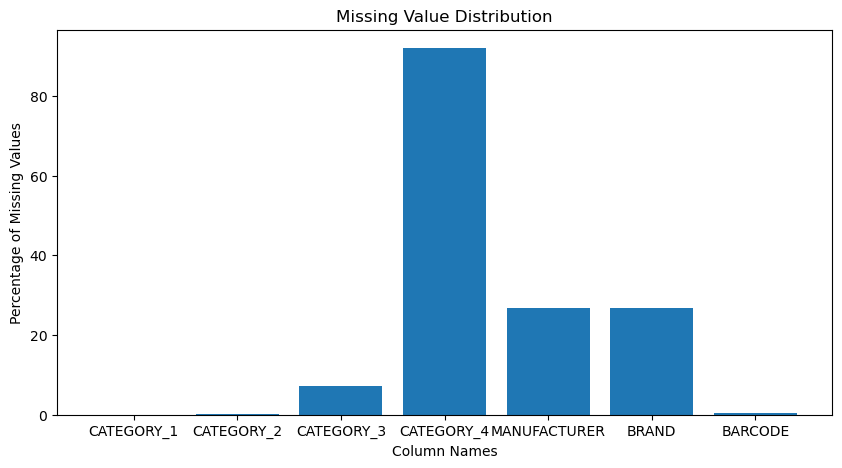

In [303]:
products_missing_perc = (products_df.isnull().sum() / len(products_df)) * 100

plt.figure(figsize=(10, 5))

plt.bar(products_missing_perc.index, products_missing_perc)

plt.xlabel('Column Names')

plt.ylabel('Percentage of Missing Values')

plt.title('Missing Value Distribution')

plt.show()

## Missing values in Products Data


*   .5% of data is missing in barcode. Since it is the foreign key in transactions, we must remove the rows with missing bar codes.
*   Manufacturer and brand are always missing together.
* More than 90% of the products have only 3 nested categories
* Category 4, sparse data makes it usefulness unclear

## Barcode Cleaning
We need to standardize the barcode across all rows since it has variable length. We will do that by converting it to Integer first and then to String and pad any leading zeros to make every barcode of length 14 according to international standard.

In [304]:
def clean_barcode(df_to_clean):
    df_to_clean = df_to_clean.copy()

    # First drop any rows where BARCODE is NA
    df_to_clean = df_to_clean.dropna(subset=['BARCODE'])

    # Convert to int64 then to string
    df_to_clean['BARCODE'] = df_to_clean['BARCODE'].astype(np.int64).astype(str)

    # Maximum length of all barcodes is found out to be 14 according to international standard
    max_len = 14

    # Apply zfill to pad leading zeros to make length of each barcode 14
    df_to_clean['BARCODE'] = df_to_clean['BARCODE'].str.zfill(max_len)

    return df_to_clean  # Added return statement to get the cleaned dataframe


In [305]:
products_df_clean = clean_barcode(products_df)

We also need to also eliminate any duplicates in the Products database on BARCODE since it's a primary key

# Users dataset cleaning

First, we will look at the missing values in each column.



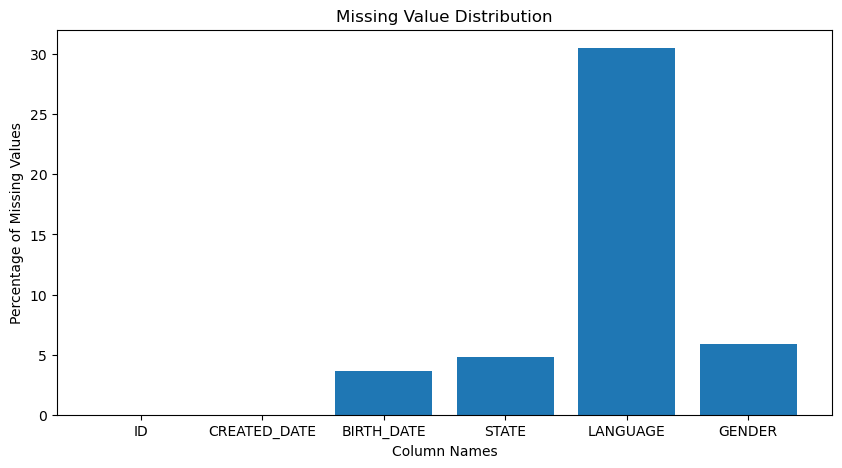

In [306]:
users_missing_perc = (users_df.isnull().sum() / len(users_df)) * 100

plt.figure(figsize=(10, 5))

plt.bar(users_missing_perc.index, users_missing_perc)

plt.xlabel('Column Names')

plt.ylabel('Percentage of Missing Values')

plt.title('Missing Value Distribution')

plt.show()

In [307]:
# Convert all the datetime fields for easier import into sql
users_df['CREATED_DATE'] = pd.to_datetime(users_df['CREATED_DATE'], utc=True)
users_df['BIRTH_DATE'] = pd.to_datetime(users_df['BIRTH_DATE'], utc=True)
users_df['ID'] = users_df['ID'].astype(str);

In [308]:
# Strip any leading or following blank spaces
users_df['ID'] = users_df['ID'].str.strip()

In [309]:
# Check the number of duplicates first
duplicate_count = users_df.duplicated(subset=['ID']).sum()
print(f"Number of duplicate entries based on ID: {duplicate_count}")

Number of duplicate entries based on ID: 0


In [310]:
# Check for unique values
print("Unique values in ID column:", users_df['ID'].nunique())
print("\nSample of ID values:", users_df['ID'].head())

# Check for NaN values
print("\nNumber of NaN values:", users_df['ID'].isna().sum())

Unique values in ID column: 100000

Sample of ID values: 0    5ef3b4f17053ab141787697d
1    5ff220d383fcfc12622b96bc
2    6477950aa55bb77a0e27ee10
3    658a306e99b40f103b63ccf8
4    653cf5d6a225ea102b7ecdc2
Name: ID, dtype: object

Number of NaN values: 0


## Invalid date rows removal

Evaluate invalid dates which could be when birthdate is in future or created date is in future or birthdate is greater than created date

In [311]:
# Current date for checking future dates
current_date = pd.Timestamp.now(tz='UTC')

invalid_date_rows = (users_df['BIRTH_DATE'] > current_date) | \
                      (users_df['CREATED_DATE'] > current_date) | \
                      (users_df['BIRTH_DATE'] > users_df['CREATED_DATE'])

# Remove all the rows with invalid dates
users_df_clean = users_df[~invalid_date_rows]

# Reset the index after cleaning
users_df_clean = users_df_clean.reset_index(drop=True)

## Data Augmentation
Compute a derived field age from the birthdate and current date

In [312]:
# Check the number of duplicates first
duplicate_count = products_df_clean.duplicated(subset=['BARCODE']).sum()
print(f"Number of duplicate entries based on BARCODE: {duplicate_count}")

# Remove duplicates keeping the first occurrence
products_df_clean = products_df_clean.drop_duplicates(subset=['BARCODE'], keep='first')

# Verify the removal
print("\nShape of DataFrame after removing duplicates:", products_df_clean.shape)

# Reset index if needed
products_df_clean = products_df_clean.reset_index(drop=True)

Number of duplicate entries based on BARCODE: 486740

Shape of DataFrame after removing duplicates: (354787, 7)


In [313]:
# Calculate the age by subtracting BIRTH_DATE from the current date
users_df_clean['AGE'] = users_df_clean['BIRTH_DATE'].apply(
    lambda birth_date: current_date.year - birth_date.year - (
            (current_date.month, current_date.day) < (birth_date.month, birth_date.day)
    )
)

# Transaction Dataset cleaning
First, we check for missing values in each column

In [314]:
# Check for missing values in transactions_df
transactions_missing_perc = (transactions_df.isnull().sum() / len(transactions_df)) * 100
print("Percentage of missing values in each column:\n", transactions_missing_perc)


Percentage of missing values in each column:
 RECEIPT_ID         0.000
PURCHASE_DATE      0.000
SCAN_DATE          0.000
STORE_NAME         0.000
USER_ID            0.000
BARCODE           11.524
FINAL_QUANTITY     0.000
FINAL_SALE         0.000
dtype: float64


## Daily Transaction Volume Trend Chart

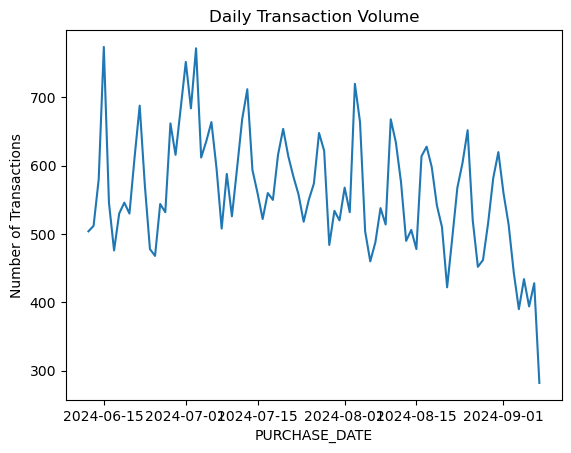

In [315]:
transaction_volume_df = transactions_df.copy()
transaction_volume_df['PURCHASE_DATE'] = pd.to_datetime(transaction_volume_df['PURCHASE_DATE'])
transaction_volume_df.groupby(transaction_volume_df['PURCHASE_DATE'].dt.date).size().plot(kind='line')
plt.title('Daily Transaction Volume')
plt.ylabel('Number of Transactions')

plt.show()

In [316]:
# Dropping any rows with missing barcode values and standardizing it with length 14 by padding leading zeros
transactions_df_clean = clean_barcode(transactions_df)

In [317]:
# Converting date fields for easier export into sql
transactions_df_clean['PURCHASE_DATE'] = pd.to_datetime(transactions_df_clean['PURCHASE_DATE'], utc=True)
transactions_df_clean['SCAN_DATE'] = pd.to_datetime(transactions_df_clean['SCAN_DATE'], utc=True)

In [318]:
print(transactions_df_clean.head())

                             RECEIPT_ID             PURCHASE_DATE  \
1  000239aa-3478-453d-801e-66a82e39c8af 2024-06-18 00:00:00+00:00   
2  0002d8cd-1701-4cdd-a524-b70402e2dbc0 2024-06-24 00:00:00+00:00   
3  00096c49-8b04-42f9-88ce-941c5e06c4a7 2024-08-19 00:00:00+00:00   
5  0019ec79-cbb3-41ed-b84c-cd74d04553f8 2024-06-25 00:00:00+00:00   
6  001f2f3f-1746-4217-a98f-73c63c63bae2 2024-08-20 00:00:00+00:00   

                         SCAN_DATE STORE_NAME                   USER_ID  \
1 2024-06-19 11:03:37.468000+00:00  FOOD LION  63fcd7cea4f8442c3386b589   
2 2024-06-24 19:44:54.247000+00:00    WALMART  5dcc6c510040a012b8e76924   
3 2024-08-21 17:35:21.902000+00:00     TARGET  6144f4f1f3ef696919f54b5c   
5 2024-06-25 13:15:31.270000+00:00     COSTCO  5c62145dba25631369c28f32   
6 2024-08-22 12:53:37.811000+00:00    WALMART  5f57cc80a2b29216020fc68d   

          BARCODE FINAL_QUANTITY FINAL_SALE  
1  00783400000000           zero       3.49  
2  00681131000000           zero       1.4

In [319]:
print(transactions_df_clean.shape)

(44238, 8)


## Data cleaning for FINAL_SALE
Data quality issues found out:
- There are many blank fields
- There are many zeros
- Final sale is zero even if final quantity is greater than 0
- There are outliers - huge values even when the final quantity is 0

In [320]:
# First strip and leading or following blank spaces
transactions_df_clean['FINAL_SALE'] = transactions_df_clean['FINAL_SALE'].str.strip()

# Replace empty strings with zero
transactions_df_clean['FINAL_SALE'] = transactions_df_clean['FINAL_SALE'].replace("", 0)

# Convert strings to float
transactions_df_clean['FINAL_SALE'] = transactions_df_clean['FINAL_SALE'].astype(float)

## Data cleaning for FINAL_QUANTITY

Data quality issues found out:
- There are string "zero" value but this type of column should always be numeric
- Final quantity is 0 even when the final sale is greater than 0
- There are outliers like 276 when final sale is blank

In [321]:
# First strip and leading or following blank spaces
transactions_df_clean['FINAL_QUANTITY'] = transactions_df_clean['FINAL_QUANTITY'].str.strip()

# Replace "zero" string to 0
transactions_df_clean['FINAL_QUANTITY'] = transactions_df_clean['FINAL_QUANTITY'].replace("zero", 0)

# Replace empty string to 0
transactions_df_clean['FINAL_QUANTITY'] = transactions_df_clean['FINAL_QUANTITY'].replace("", 0)

# Convert strings to float
transactions_df_clean['FINAL_QUANTITY'] = transactions_df_clean['FINAL_QUANTITY'].astype(float)

## Data cleaning for USER_ID

In [322]:
transactions_df_clean['USER_ID'] = transactions_df_clean['USER_ID'].astype(str)
transactions_df_clean['USER_ID'] = transactions_df_clean['USER_ID'].str.strip()

## Data cleaning for RECEIPT_ID

In [323]:
transactions_df_clean['RECEIPT_ID'] = transactions_df_clean['RECEIPT_ID'].astype(str)
transactions_df_clean['RECEIPT_ID'] = transactions_df_clean['RECEIPT_ID'].str.strip()

## Duplicates on RECEIPT_ID AND BARCODE
We need to eliminate duplicates on RECEIPT_ID and BARCODE since it is the primary key, but we don't want to lose any information on final quantity or final sale so we only eliminate the rows where either of them is zero since that is incomplete data.

In [324]:
# Check the number of duplicates based on RECEIPT_ID or BARCODE
duplicate_count = transactions_df_clean.duplicated(subset=['RECEIPT_ID', 'BARCODE']).sum()
print(f"Number of duplicate entries based on RECEIPT_ID and BARCODE: {duplicate_count}")

# Identify which rows have duplicates and filter those rows where FINAL_SALES or FINAL_QTY is zero
duplicates_to_remove = transactions_df_clean.duplicated(subset=['RECEIPT_ID', 'BARCODE'], keep=False) & (
        (transactions_df_clean['FINAL_SALE'] == 0) | (transactions_df_clean['FINAL_QUANTITY'] == 0)
)

# Remove only the duplicates that meet the condition, keeping the first occurrence
transactions_df_clean = transactions_df_clean[
    ~(duplicates_to_remove & transactions_df_clean.duplicated(subset=['RECEIPT_ID', 'BARCODE'], keep='first'))]

# Verify and reset the index
print("\nShape of DataFrame after conditionally removing duplicates:", transactions_df_clean.shape)
transactions_df_clean = transactions_df_clean.reset_index(drop=True)

Number of duplicate entries based on RECEIPT_ID and BARCODE: 22261

Shape of DataFrame after conditionally removing duplicates: (43982, 8)


In [325]:
# Grouping by RECEIPT_ID and counting unique BARCODEs for each RECEIPT_ID
receipt_barcode_count = transactions_df_clean.groupby('RECEIPT_ID')['BARCODE'].nunique()

# Check if any RECEIPT_ID maps to more than one BARCODE
multi_barcode_receipts = receipt_barcode_count[receipt_barcode_count > 1]

# Print the results
print(f"Number of RECEIPT_IDs mapping to more than one BARCODE: {len(multi_barcode_receipts)}")
print("Sample of RECEIPT_IDs with multiple BARCODEs:")
print(multi_barcode_receipts.head())


Number of RECEIPT_IDs mapping to more than one BARCODE: 327
Sample of RECEIPT_IDs with multiple BARCODEs:
RECEIPT_ID
019520fd-f28b-42ff-a29e-d6bf4f5c4b7c    2
01d0e64c-0b62-405f-a7bf-2dc04c36a53d    2
0373c1d8-3cc9-4cb2-a4f9-ddc7a974b671    2
0386ab8c-8a01-4479-8ee7-eb82a72a4895    2
048cbab3-cc04-4feb-b465-4ecf83d4d11e    2
Name: BARCODE, dtype: int64


## Data transformation for zero values of FINAL_SALE and FINAL_QUANTITY

First, we evaluate the number of rows with final sales as 0 and final quantity as 0


In [326]:
zero_final_sales_count = len(transactions_df_clean[transactions_df_clean['FINAL_SALE'] == 0])
zero_final_quantity_count = len(transactions_df_clean[transactions_df_clean['FINAL_QUANTITY'] == 0])
print("Final sales zero count: " + str(zero_final_sales_count))
print("Final quantity zero count: "+ str(zero_final_quantity_count))


Final sales zero count: 10968
Final quantity zero count: 11066


Now, we try to find the price of each barcode by using final_sale/final_quantity where both of them are non-zero. We substitute these computed values for transactions where either of them is missing by using final_sale = final_quantity * price_of_barcode or final_quantity = final_sale / price_of_barcode. In cases, where there are multiple values found for a barcode, we take the mean of these values to substitute in the explained formulas.

In [327]:
from collections import defaultdict

barcode_to_prices = defaultdict(list)
for index, row in transactions_df_clean.iterrows():
    final_sale = row['FINAL_SALE']
    final_quantity = row['FINAL_QUANTITY']
    price = final_sale / final_quantity if final_quantity > 0 else 0
    if price == 0:
        continue
    barcode = row['BARCODE']
    barcode_to_prices[barcode].append(price)

barcode_to_avg_price = {}
for barcode, prices in barcode_to_prices.items():
    barcode_to_avg_price[barcode] = sum(prices) / len(prices)

In [328]:
print(len(barcode_to_avg_price.keys()))

9016


In [329]:
print(transactions_df_clean.shape)

(43982, 8)


In [330]:
# Applying the substitutions for zero values of FINAL_SALE
transactions_df_clean['FINAL_SALE'] = transactions_df_clean.apply(
    lambda row: barcode_to_avg_price[row['BARCODE']] * row['FINAL_QUANTITY']
    if row['FINAL_SALE'] == 0 and row['BARCODE'] in barcode_to_avg_price else row['FINAL_SALE'], axis=1
)

In [331]:
# Applying the substitutions for zero values of FINAL_QUANTITY
transactions_df_clean['FINAL_QUANTITY'] = transactions_df_clean.apply(
    lambda row: row['FINAL_SALE'] / barcode_to_avg_price[row['BARCODE']]
    if row['FINAL_QUANTITY'] == 0 and row['BARCODE'] in barcode_to_avg_price else row['FINAL_QUANTITY'], axis=1
)

In [332]:
zero_final_sales_count = len(transactions_df_clean[transactions_df_clean['FINAL_SALE'] == 0])
zero_final_quantity_count = len(transactions_df_clean[transactions_df_clean['FINAL_QUANTITY'] == 0])
print("Final sales zero count: " + str(zero_final_sales_count))
print("Final quantity zero count: "+ str(zero_final_quantity_count))

Final sales zero count: 64
Final quantity zero count: 57


In [333]:
# Group by RECEIPT_ID and BARCODE
transactions_df_clean = transactions_df_clean.groupby(['RECEIPT_ID', 'BARCODE']).agg({
    'FINAL_SALE': 'mean',
    'FINAL_QUANTITY': 'mean',
    **{col: 'first' for col in transactions_df_clean.columns if
       col not in ['RECEIPT_ID', 'BARCODE', 'FINAL_SALE', 'FINAL_QUANTITY']}
}).reset_index()


In the end, only 64 items of final sales as zero are remaining starting from 10638 items and only 57 items of final quantity as zero are remaining starting from 11058 items before the cleaning

Now, we remove the duplicates based on RECEIPT_ID by grouping the records by RECEIPT_ID and taking the mean of FINAL_SALE AND FINAL QUANTITY

In [334]:
print(transactions_df_clean.shape)

(21977, 8)


In [335]:
products_df_clean.to_csv(data_root + 'products_clean.csv', index=False)
users_df_clean.to_csv(data_root + 'users_clean.csv', index=False)
transactions_df_clean.to_csv(data_root + 'transactions_clean.csv', index=False)

In [336]:
df_combined = users_df_clean.merge(transactions_df_clean, left_on='ID', right_on='USER_ID', how='inner').merge(products_df_clean, how='inner')

In [337]:
print(df_combined.shape)

(75, 21)


# Data Analysis

## Sales Distributions by Generation

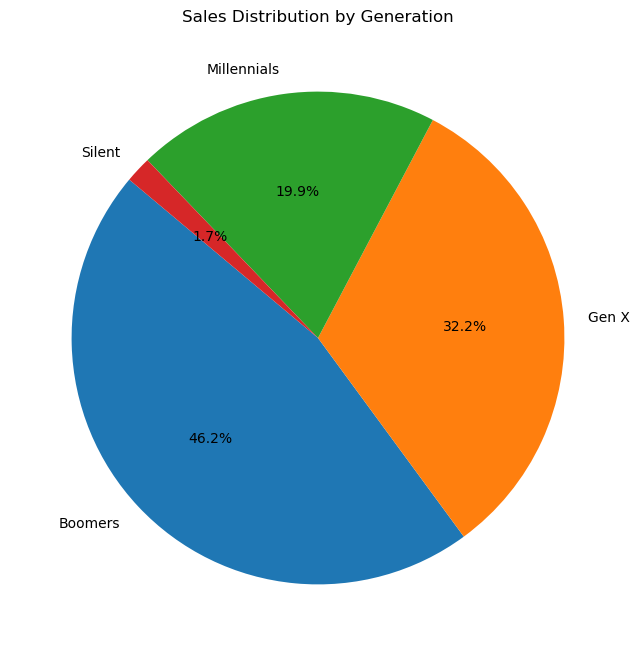

In [338]:
df_combined['GENERATION'] = df_combined['AGE'].apply(
    lambda age: 'Gen Z' if age < 26 else
                'Millennials' if 26 <= age <= 41 else
                'Gen X' if 42 <= age <= 57 else
                'Boomers' if 58 <= age <= 76 else
                'Silent'
)

sales_by_generation = df_combined.groupby('GENERATION')['FINAL_SALE'].sum()
sales_by_generation = sales_by_generation.sort_index()

plt.figure(figsize=(8, 8))
plt.pie(sales_by_generation, labels=sales_by_generation.index, autopct='%1.1f%%', startangle=140)
plt.title('Sales Distribution by Generation')
plt.show()

## Most purchased category by Generations

In [339]:
# Group by GENERATION and CATEGORY_1, then count the number of unique RECEIPT_IDs
category_counts = (
    df_combined.groupby(['GENERATION', 'CATEGORY_1'])['RECEIPT_ID']
    .nunique()
    .reset_index(name='COUNT')
)

# Identify the most popular CATEGORY_1 for each generation based on the highest RECEIPT_ID count
most_popular_categories = category_counts.loc[category_counts.groupby('GENERATION')['COUNT'].idxmax()]

# Display the result in a DataFrame format
print(most_popular_categories)

    GENERATION CATEGORY_1  COUNT
3      Boomers     Snacks     13
6        Gen X     Snacks     18
8  Millennials     Snacks     12
9       Silent     Snacks      3


## Category wise total sales

In [340]:
# Group products by "Category 1" and calculate the sum of FINAL_SALE for each group
top_categories = (
    df_combined.groupby('CATEGORY_1')['FINAL_SALE']
    .sum()
    .sort_values(ascending=False)
    .head(3)
)

# Display the results
print("Top 3 Category 1 values by FINAL_SALE:")
print(top_categories)


Top 3 Category 1 values by FINAL_SALE:
CATEGORY_1
Health & Wellness    193.767699
Snacks               172.225987
Alcohol               17.480000
Name: FINAL_SALE, dtype: float64


## Number of common users in top 2 categories

In [341]:
# Filter users with CATEGORY_1 as 'Snacks'
snacks_users = set(df_combined[df_combined['CATEGORY_1'] == 'Snacks']['USER_ID'])

# Filter users with CATEGORY_1 as 'Health & Wellness'
health_wellness_users = set(df_combined[df_combined['CATEGORY_1'] == 'Health & Wellness']['USER_ID'])

# Find the intersection of the two sets
common_users = snacks_users.intersection(health_wellness_users)

# Display the result
print(f"Number of common users: {len(common_users)}")
print(common_users)

Number of common users: 4
{'646bdaa67a342372c857b958', '5b441360be53340f289b0795', '5ca54049adfcb4140b54e1bf', '65044dc5fe41d365c2ed7d71'}


## Top Subcategory in Snacks

In [342]:
# Filter rows where CATEGORY_1 is 'Snacks'
filtered_df = df_combined[
    df_combined['CATEGORY_1'].isin(['Snacks'])
]

# Group by CATEGORY_2 and count unique RECEIPT_IDs
category_2_receipt_count = (
    filtered_df.groupby('CATEGORY_2')['RECEIPT_ID']
    .nunique()
    .reset_index()
    .rename(columns={'RECEIPT_ID': 'RECEIPT_COUNT'})
    .sort_values(by='RECEIPT_COUNT', ascending=False)
)

# Get the top CATEGORY_2
top_category_2 = category_2_receipt_count.iloc[0]

# Display the result
print(f"Top CATEGORY_2: {top_category_2['CATEGORY_2']} with {top_category_2['RECEIPT_COUNT']} unique RECEIPT_IDs.")


Top CATEGORY_2: Candy with 16 unique RECEIPT_IDs.


## Top Subcategory in Health & Wellness

In [343]:
# Filter rows where CATEGORY_1 is 'Health & Wellness'
filtered_df = df_combined[
    df_combined['CATEGORY_1'].isin(['Health & Wellness'])
]

# Group by CATEGORY_2 and count unique RECEIPT_IDs
category_2_receipt_count = (
    filtered_df.groupby('CATEGORY_2')['RECEIPT_ID']
    .nunique()
    .reset_index()
    .rename(columns={'RECEIPT_ID': 'RECEIPT_COUNT'})
    .sort_values(by='RECEIPT_COUNT', ascending=False)
)

# Get the top CATEGORY_2
top_category_2 = category_2_receipt_count.iloc[0]

# Display the result
print(f"Top CATEGORY_2: {top_category_2['CATEGORY_2']} with {top_category_2['RECEIPT_COUNT']} unique RECEIPT_IDs.")

Top CATEGORY_2: Bath & Body with 7 unique RECEIPT_IDs.


## Top 5 brands in the best selling categories

In [344]:
# For Health & Wellness
health_wellness_top5_sales = (
    df_combined[df_combined['CATEGORY_1'] == 'Health & Wellness']
    .groupby('BRAND')['FINAL_SALE']
    .sum()
    .reset_index()
    .sort_values(by='FINAL_SALE', ascending=False)
    .head(5)
)

# For Snacks
snacks_top5_sales = (
    df_combined[df_combined['CATEGORY_1'] == 'Snacks']
    .groupby('BRAND')['FINAL_SALE']
    .sum()
    .reset_index()
    .sort_values(by='FINAL_SALE', ascending=False)
    .head(5)
)

# Display results
print("Top 5 Brands in Health & Wellness by FINAL_SALE:")
print(health_wellness_top5_sales)

print("\nTop 5 Brands in Snacks by FINAL_SALE:")
print(snacks_top5_sales)

Top 5 Brands in Health & Wellness by FINAL_SALE:
             BRAND  FINAL_SALE
4              CVS   72.000000
5             DOVE   31.042500
2   CORICIDIN® HBP   21.322806
16        TRESEMMÉ   14.580000
3            CREST    8.970000

Top 5 Brands in Snacks by FINAL_SALE:
              BRAND  FINAL_SALE
37          TRIDENT   23.360000
26  PEPPERIDGE FARM   11.932222
12      GREAT VALUE    9.300000
28           QUAKER    8.300000
8         FITCRUNCH    6.980000


## The leading brands by FINAL_SALE

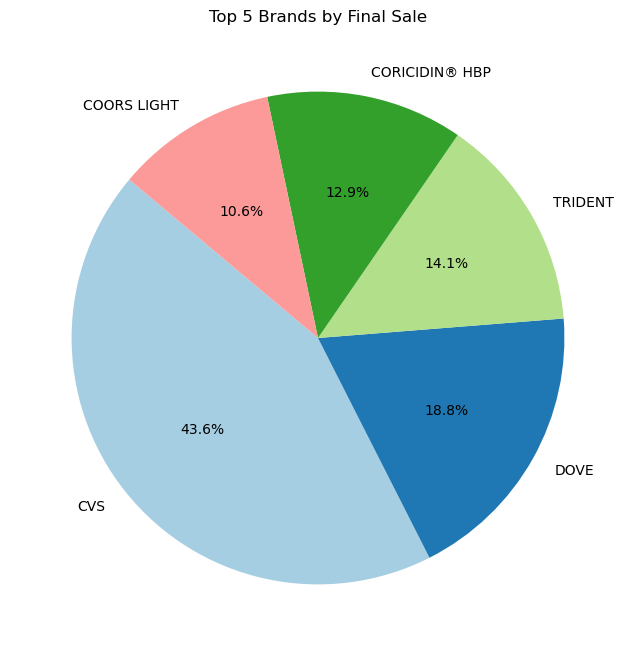

In [345]:
# Grouping by BRAND and aggregating FINAL_SALE, then sorting and selecting the top 5
top5_brands_by_sale = (
    df_combined.groupby('BRAND')['FINAL_SALE']
    .sum()
    .reset_index()
    .sort_values(by='FINAL_SALE', ascending=False)
    .head(5)
)

# Pie chart labels and values
labels = top5_brands_by_sale['BRAND']
values = top5_brands_by_sale['FINAL_SALE']

# Creating the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    values,
    labels=labels,
    autopct='%1.1f%%',  # Shows percentages on the chart
    startangle=140,  # Rotate the chart for better visualization
    colors=plt.cm.Paired.colors  # Set colors
)
plt.title('Top 5 Brands by Final Sale')
plt.show()


## Prime day for shopping

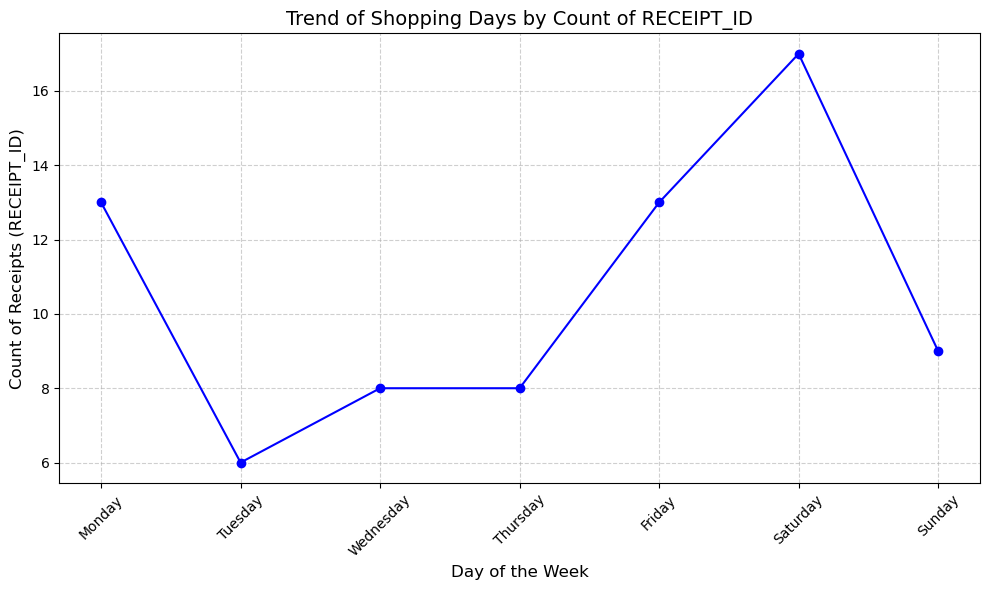

In [346]:
df_combined['DAY_OF_WEEK'] = df_combined['PURCHASE_DATE'].dt.day_name()
# Group by day of the week and count the number of distinct RECEIPTS_ID
peak_shopping_days = (
    df_combined.groupby('DAY_OF_WEEK')['RECEIPT_ID']
    .nunique()
    .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])  # Reorder days
)
# Plot the trend as a line chart
plt.figure(figsize=(10, 6))
plt.plot(peak_shopping_days.index, peak_shopping_days.values, marker='o', linestyle='-', color='b')

# Formatting the chart
plt.title('Trend of Shopping Days by Count of RECEIPT_ID', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Count of Receipts (RECEIPT_ID)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

## Prime month of shopping

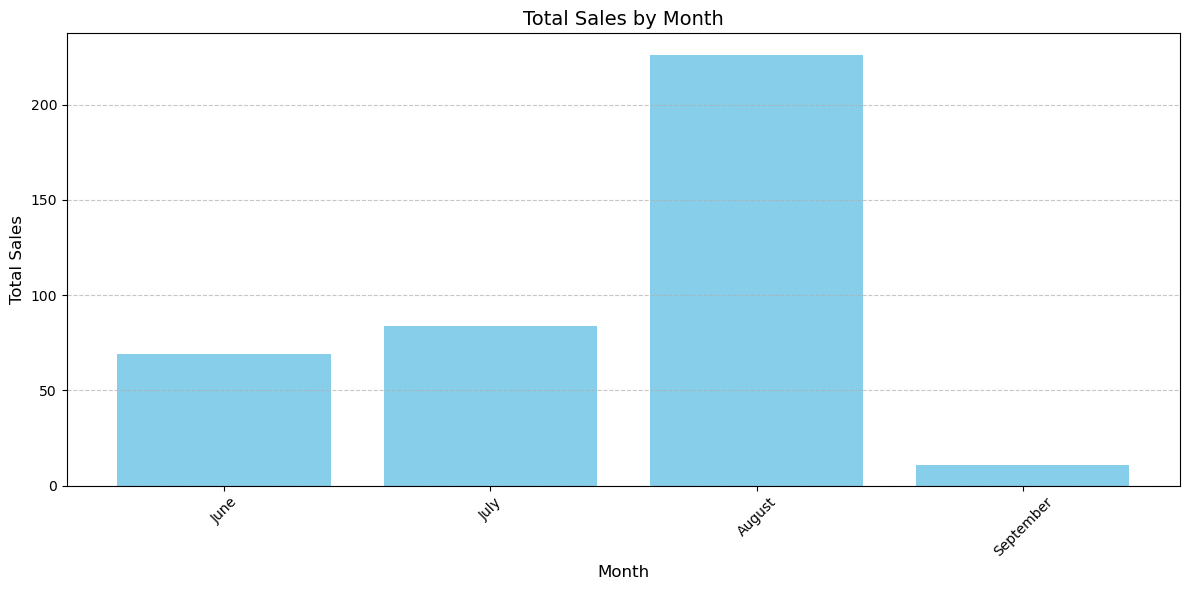

In [347]:
# Extract the month name from PURCHASE_DATE
df_combined['MONTH'] = df_combined['PURCHASE_DATE'].dt.month_name()

# Group by month and sum the sales (assuming 'FINAL_SALE' represents sales value)
monthly_sales = (
    df_combined.groupby('MONTH')['FINAL_SALE']
    .sum()
    .reindex([
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    ])  # Reorder months
)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(monthly_sales.index, monthly_sales.values, color='skyblue')

# Formatting the chart
plt.title('Total Sales by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


## Top brands by number of repeat customers

The brand with the highest number of repeat customers is 'NERDS CANDY' with 1 repeat customers.
Top 5 brands with the highest repeat customers:
BRAND
NERDS CANDY    1
TRIDENT        1
Name: USER_ID, dtype: int64


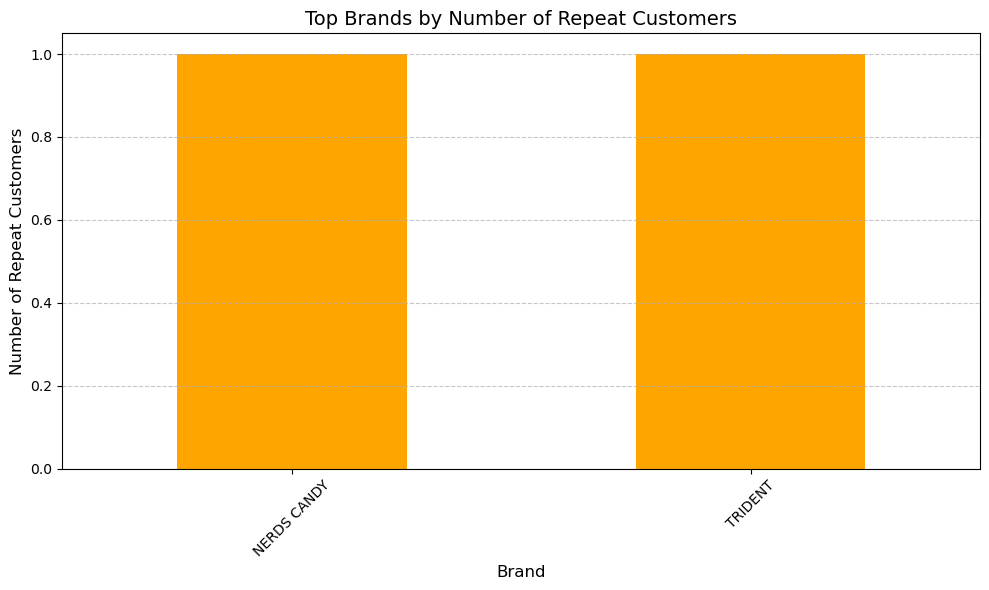

In [348]:
# Group the data by USER_ID and BRAND and count purchases for each combination
user_brand_counts = df_combined.groupby(['USER_ID', 'BRAND']).size().reset_index(name='purchase_count')

# Identify repeat purchases (USER_IDs with more than 1 purchase for the same BRAND)
repeat_customers = user_brand_counts[user_brand_counts['purchase_count'] > 1]

# Count the number of repeat customers per BRAND
repeat_customers_per_brand = repeat_customers.groupby('BRAND')['USER_ID'].nunique()

# Find the brand with the highest number of repeat customers
highest_repeat_customers_brand = repeat_customers_per_brand.idxmax()
highest_repeat_customers_count = repeat_customers_per_brand.max()

# Display results
print(
    f"The brand with the highest number of repeat customers is '{highest_repeat_customers_brand}' with {highest_repeat_customers_count} repeat customers.")

# Optional: Display the top 5 brands with the highest repeat customer count
top_repeat_brands = repeat_customers_per_brand.sort_values(ascending=False).head()
print("Top 5 brands with the highest repeat customers:")
print(top_repeat_brands)

# Plot a bar chart for the top 5 brands with the highest repeat customers
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_repeat_brands.plot(kind='bar', color='orange')

# Chart formatting
plt.title('Top Brands by Number of Repeat Customers', fontsize=14)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Number of Repeat Customers', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()
